<a href="https://colab.research.google.com/github/nathaliedees/thesis/blob/master/cnn_orthophotomosaic_test_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as Img
from PIL import ImageTk

import os
import sklearn.preprocessing as skl
import sklearn.metrics as skm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/'My Drive'/Master/Data

/content/drive/My Drive/Master/Data


In [4]:
CUDA_LAUNCH_BLOCKING=1

In [5]:
%ls

aug/


In [6]:
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
# etc, etc, etc

path=Path('/content/drive/My Drive/Master/Data/aug/backup')

In [7]:
path.ls()

[PosixPath('/content/drive/My Drive/Master/Data/aug/backup/test'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/results')]

In [8]:
#import training images
fnames = get_image_files(path/'trainData')
fnames[:5]

[PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData/augmented_3.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData/augmented_2.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData/augmented_1.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData/augmented_5.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainData/augmented_7.png')]

In [9]:
#import training labels
lbl_names = get_image_files(path/'trainAnnotate')
lbl_names[:5]


[PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_17.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_1.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_3.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_16.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_19.png')]

In [10]:
#make sure every label matches with training image
def get_y_fn(x): return Path(str(x.parent)[:-4]+'Annotate')/x.name

In [11]:
x=get_y_fn(path/'trainData/augmented_60.png')
x

PosixPath('/content/drive/My Drive/Master/Data/aug/backup/trainAnnotate/augmented_60.png')

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 2, 2,  ..., 3, 3, 0],
         [0, 2, 2,  ..., 3, 3, 0],
         ...,
         [0, 2, 2,  ..., 3, 3, 0],
         [0, 2, 2,  ..., 3, 3, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

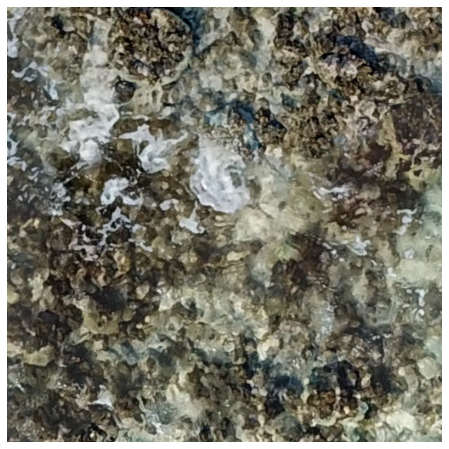

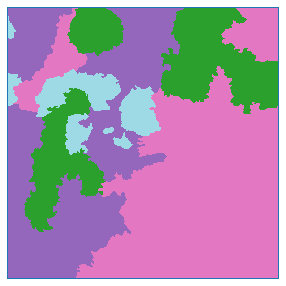

In [72]:
r_index = random.randint(0, len(fnames)-1)
#show some data
img_f = fnames[r_index]
img = open_image(img_f)
img.show(figsize=(8,8))

#show mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

#sr_size=np.array(img.shape[1:])
mask.data

In [73]:
src_size = np.array(mask.shape[1:])
print(mask)
src_size,mask.data

print('Size: {}'.format(src_size))
t = mask.data
a = t.reshape(1, -1).squeeze()
n = to_np(a)
u = []
for i in n:
  if i not in u:
    u.append(i)
print(sorted(u))
len(u)

ImageSegment (1, 512, 512)
Size: [512 512]
[0, 1, 2, 3, 5]


5

In [12]:
codes = np.array(['nodata',
         'coral', 
         'rubble', 
         'shallow water/sand', 
         'rock', 
         'waves'])

In [13]:
bs = 2

In [14]:
data = (SegmentationItemList.from_folder(path/'trainData')
       #.split_by_folder(train=train, valid=path/'aug/valData') #splitting data by folder (make separate validation set)
       #.split_none()                                           #do not split data
       .split_by_rand_pct(0.25)                                  #split random -> put one of these on
       .label_from_func(get_y_fn, classes=codes)
       .databunch(bs=bs).normalize())                              #can be normalized on imagenetstats

In [15]:
#add test set
test_data = ImageList.from_folder(path/'test')
data.add_test(test_data)

In [16]:
data

ImageDataBunch;

Train: LabelList (98 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/backup/trainData;

Valid: LabelList (32 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/backup/trainData;

Test: LabelList (410 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Master/Data/aug/backup/t

In [ ]:
print(data.classes)

['nodata' 'coral' 'rocks' 'rubble' 'shallow water/sand' 'waves']


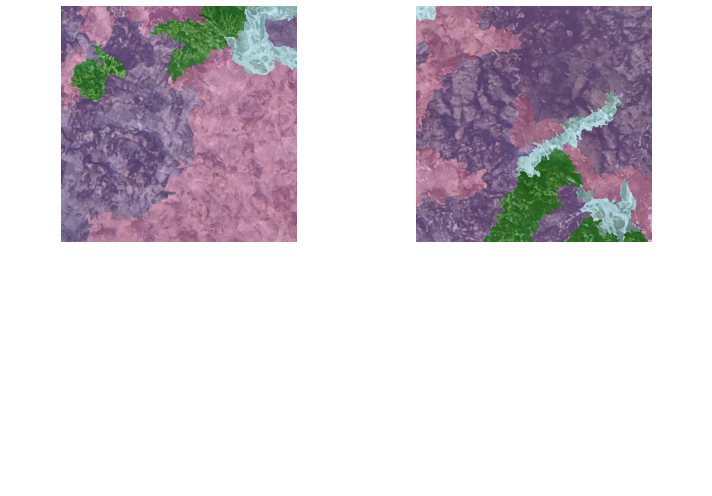

In [ ]:
data.show_batch(2, figsize=(10,7))

In [17]:
#https://forums.fast.ai/t/create-databunch-with-multiple-segmentation-mask-as-label/53643/21
#custom accuracy class, otherwise the learner does not work due to tensor size errors.
def cust_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [18]:
#https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/3
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    #intersection_class= troch
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [19]:
wd=0.01
learn = unet_learner(data, models.resnet34, 
                     metrics=[cust_accuracy, IoU],
                     wd=wd) 
                    # loss_func = nn.CrossEntropyLossFlat())  #loss function compatible in fastai 2 however, not sure how to implement it now
                     #bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


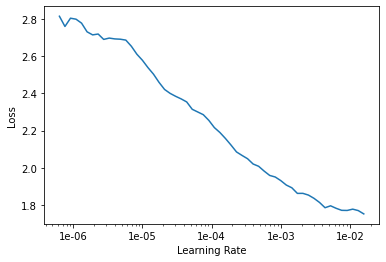

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
#chose best lr from plot
lr=1e-4
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(5, slice(lr))
#if this worked fine; no weird numbers and nans, tweaking can beglearnin

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,1.635166,1.258879,0.454816,0.110355,01:11
1,1.243156,0.922735,0.621964,0.170855,00:52
2,1.064785,0.967390,0.632189,0.177471,00:52
3,0.945309,0.831343,0.673909,0.223801,00:52
4,0.884465,0.807820,0.668532,0.222413,00:52


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)


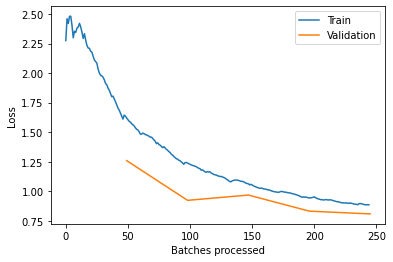

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.824823,0.769379,0.694621,0.240182,00:52
1,0.829607,0.838941,0.645246,0.240180,00:52
2,0.805432,0.760263,0.711251,0.288213,00:52
3,0.728382,0.663323,0.745136,0.335162,00:52
4,0.658224,0.650214,0.747637,0.334469,00:52


In [ ]:
learn.save('stage-1_b')

In [ ]:
learn.load('stage-1_b');

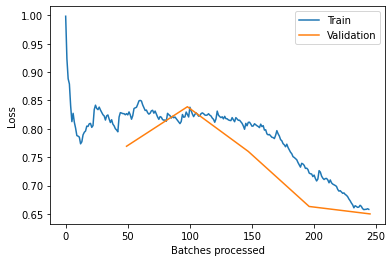

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.608182,0.639295,0.751162,0.343970,00:55
1,0.573124,0.620730,0.764358,0.363704,00:55
2,0.556680,0.618107,0.772047,0.388443,00:55
3,0.543881,0.620986,0.757012,0.368864,00:55
4,0.525864,0.596072,0.766904,0.408404,00:55
5,0.505319,0.551812,0.792299,0.428974,00:55
6,0.490961,0.571648,0.780435,0.407729,00:55
7,0.474388,0.590903,0.777570,0.459646,00:55
8,0.420863,0.523193,0.805067,0.477339,00:55
9,0.360740,0.475125,0.822894,0.505941,00:55


In [ ]:
learn.save('stage-2_b');

In [ ]:
learn.load('stage-2_b');

In [ ]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.230667,0.505255,0.822793,0.518446,00:54
1,0.219988,0.519175,0.828877,0.533742,00:55
2,0.210277,0.477228,0.838408,0.542138,00:55


In [ ]:
learn.save('final_b')

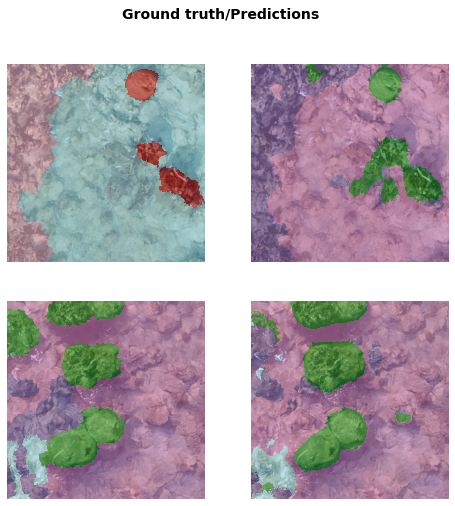

In [ ]:
learn.show_results()

In [20]:
learn.load('final_b')

Learner(data=ImageDataBunch;

Train: LabelList (98 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/backup/trainData;

Valid: LabelList (32 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/backup/trainData;

Test: LabelList (410 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Master/Data

In [21]:
valids =learn.get_preds(ds_type = DatasetType.Valid)
valids[0].shape

torch.Size([32, 6, 512, 512])

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 1, 1, 1, ..., 2, 2, 2, 0],
       [0, 1, 2, 1, ..., 2, 2, 2, 0],
       [0, 1, 1, 1, ..., 2, 2, 1, 0],
       ...,
       [0, 2, 2, 2, ..., 2, 2, 2, 0],
       [0, 2, 2, 2, ..., 2, 2, 2, 0],
       [0, 2, 2, 2, ..., 2, 2, 2, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

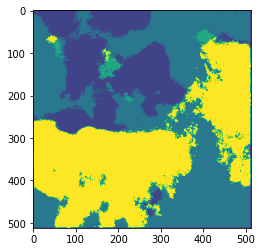

In [125]:
predicted_masks = np.argmax(valids[0],axis=1)
for i in range(len(predicted_masks)):
  Mask = (to_np(predicted_masks[i]))
  plt.imshow(Mask)

Mask

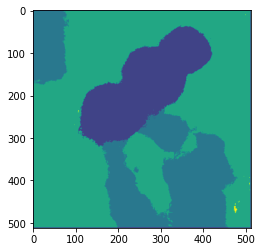

In [132]:
pred_v = valids[0][4]
pred_argmax = pred_v.argmax(dim=0)
plt.imshow(pred_argmax)

In [127]:
datasetIndex = []
num = len(valids)

for i in range(num):
    datasetIndex.append(str(valids.items[i]).split('/')[-1])

AttributeError: ignored

In [22]:
ground_truth = []
classified = []

for i in range (len(learn.data.valid_ds)):
    im = np.array(Img.open(lbl_names[i]))
    ground_truth.append(im)
    pred_v = valids[0][i]
    pred_argmax = pred_v.argmax(dim=0).numpy()
    classified.append(pred_argmax)


In [23]:
gt = np.array([i for i in ground_truth])
cf = np.array([i for i in classified])


In [104]:
print(codes)

['nodata' 'coral' 'rubble' 'shallow water/sand' 'rock' 'waves']


In [106]:
#make custom function to make a confusion matrix
#https://stackoverflow.com/questions/50065484/getting-precision-recall-and-f1-score-per-class-in-keras
import sklearn
from sklearn.metrics import classification_report
#sklearn.utils.multiclass.type_of_target(classified[1].ravel())
print(classification_report(gt.ravel(), cf.ravel(), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65408
           1       0.17      0.40      0.24   1513641
           2       0.26      0.12      0.16   2376235
           3       0.45      0.19      0.27   3986888
           5       0.05      0.21      0.08    446436

    accuracy                           0.21   8388608
   macro avg       0.39      0.38      0.35   8388608
weighted avg       0.33      0.21      0.23   8388608



In [89]:
from sklearn.metrics import jaccard_score
jaccard_score(gt.ravel(), cf.ravel(), average=None)

array([0.998899, 0.133936, 0.088401, 0.153404, 0.041843])

In [90]:
r_index = random.randint(0, len(gt)-1)
print(classification_report(gt[r_index].ravel(), cf[r_index].ravel(), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2044
           1       0.19      0.42      0.26     30010
           2       0.12      0.08      0.10     54483
           3       0.61      0.27      0.37    175607
           5       0.00      0.00      0.00         0

    accuracy                           0.25    262144
   macro avg       0.38      0.35      0.34    262144
weighted avg       0.46      0.25      0.30    262144



In [91]:
jaccard_score(gt[r_index].ravel(), cf[r_index].ravel(), average=None)

array([1.      , 0.148941, 0.050455, 0.226561, 0.      ])

In [92]:
print(codes)

['nodata' 'coral' 'rubble' 'shallow water/sand' 'rock' 'waves']


In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(gt.ravel(), cf.ravel())

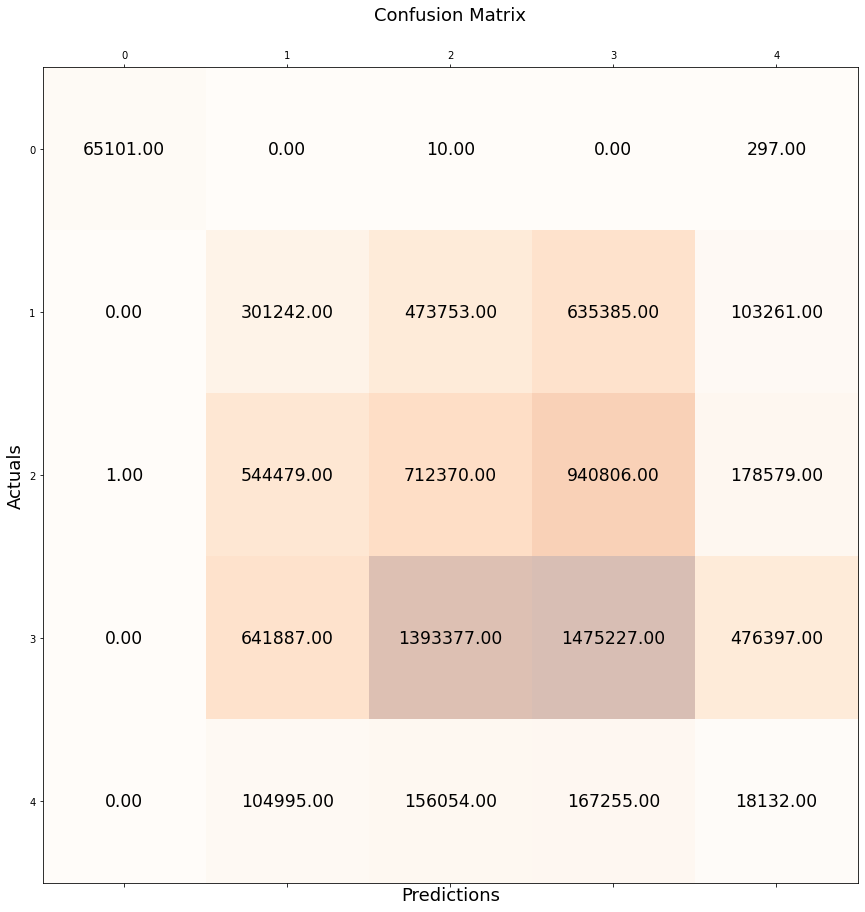

In [137]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], '.2f'), va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [28]:
#https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
conf_percentage =np.transpose( np.transpose(conf_matrix) / conf_matrix.astype(np.float).sum(axis=1) )


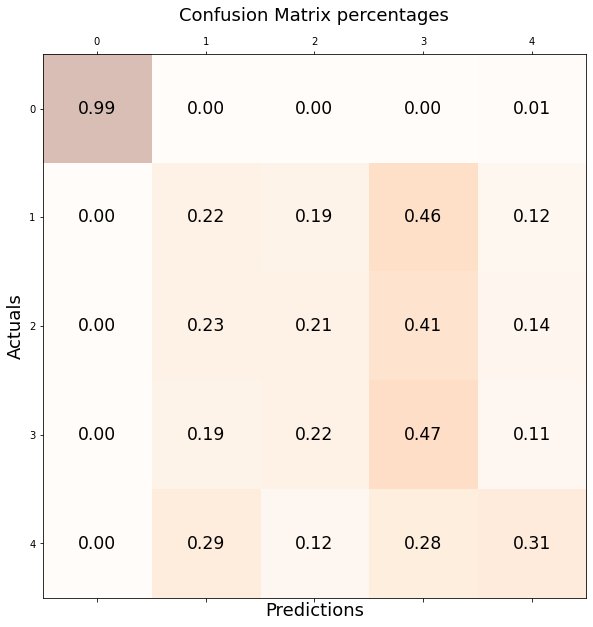

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_percentage, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_percentage.shape[0]):
    for j in range(conf_percentage.shape[1]):
        ax.text(x=j, y=i,s=format(conf_percentage[i, j], '.2f')
                , va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix percentages', fontsize=18)
plt.show()

In [ ]:
#When happy with the results, try them on the test set
test_preds=learn.get_preds(ds_type = DatasetType.Test)

In [ ]:
#https://forums.fast.ai/t/get-the-filenames-of-the-data-in-the-test-set-in-the-order-theyre-predicted/46056/6
#fast.ai feeds databunches the order of test data randomly, so assign right filenames with the right maskmask
datasetIndex = []
num = len(learn.data.test_ds)

for i in range(num):
    datasetIndex.append(str(learn.data.test_ds.items[i]).split('/')[-1])

In [ ]:
datasetIndex[1]

'tile_0220.png'

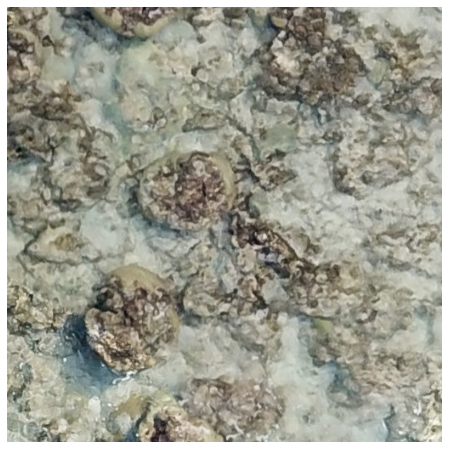

In [ ]:
testnames = get_image_files(path/'test')
#show some data
img_t = testnames[1]
img = open_image(img_t)
img.show(figsize=(8,8))

In [ ]:
#https://forums.fast.ai/t/saving-segmentation-masks-tutorial/62898
#followed this tutorial for saving the masks
test_preds[0].shape

torch.Size([410, 6, 512, 512])

In [ ]:
pred_1 = test_preds[0][1]
pred_argmax = pred_1.argmax(dim=0)

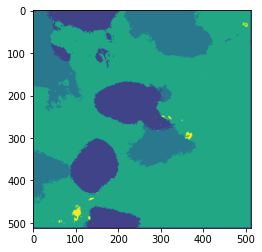

In [ ]:
plt.imshow(pred_argmax)

In [ ]:
#saving masks of testset
for i in range (0,410):
  pred_1 = test_preds[0][i]
  pred_argmax = pred_1.argmax(dim=0)
  pred_argmax = pred_argmax.numpy()
  rescaled = (255.0/pred_argmax.max() * (pred_argmax - pred_argmax.min())).astype(np.uint8)
  im = Img.fromarray(rescaled)

  im.save(str(path) + '/results/' + datasetIndex[i][:-4]+'.png')

